In [37]:
import pandas as pd
import numpy as np
import ast

from annotation_parser import parse_annotations
from keypoint_cleaner import assign_fencer_labels, interpolate_frames
from data_augmenter import duplicate_and_flip_actions, create_action_windows, augment_all_actions, split_data, explode_keypoints

from data_visualization import show_stats, plot_poses, draw_random_action, draw_random_window

PATH_ACTIONS                        = "../Data/Unprocessed/actions.xml"
PATH_ACTIONS_FILTERED               = "../Data/tmp/actions_filtered.csv"

PATH_KEYPOINTS                      = "../Data/Unprocessed/keypoints.csv"
PATH_KEYPOINTS_FILTERED             = "../Data/tmp/keypoints_filtered.csv"

PATH_METADATA                       = "../Data/Processed/metadata.csv"
PATH_DATA                           = "../Data/Processed/data.csv"



MINIMUM_DURATION                    = 4
MINIMUM_ACTION_COUNT                = 5

LOW_CONFIDENCE_THRESHOLD            = 0.7

WINDOWS_PER_ACTION                  = 5
JITTER_STD = 2.5
NOISE_STD = 2.5
SCALE_STD = 0.075
ROTATE_DEG = 7

## Annotation Cleaning

In [2]:
df = parse_annotations(PATH_ACTIONS)

df["duration"] = df["end_frame"] - df["start_frame"] + 1
df_actions = df[~df["action"].isin(["ATTACK_PREPARATION", "OTHER_NO_ACTION", "OTHER_RECOVERY"])]

show_stats(df_actions)

action,min,max,mean,std,count
ATTACK_LUNGE,2,11,7.151163,1.482983,172
ATTACK_STOP_CUT,2,15,5.067797,2.016008,59
ATTACK_STEP_CUT,3,8,5.333333,1.314257,45
ATTACK_BEAT,3,10,5.085714,1.597267,35
ATTACK_COUNTER,2,7,4.758621,1.184880,29
ATTACK_RIPOSTE,2,11,5.058824,2.135140,17
ATTACK_FEINT,3,6,4.300000,0.823273,10
ATTACK_FLUNGE,5,11,8.200000,2.201010,10
ATTACK_REMISE,4,10,6.666667,2.338090,6
ATTACK_COMPOUND,5,17,10.000000,6.244998,3


Total Offensive Actions: 389
Total Defensive Actions: 128

Total Actions: 517
Total action classes:  19



In [3]:
df_actions_short = df_actions[df_actions["duration"] < MINIMUM_DURATION]

df_filtered = df_actions[~df_actions["duration"].isin(df_actions_short["duration"])]
df_filtered = df_filtered[df_filtered.groupby("action")["action"].transform("size") >= MINIMUM_ACTION_COUNT]

show_stats(df_filtered)

df_filtered["file"] = "/" + df_filtered["source_id"] + "/" + df_filtered["clip_id"]
df_filtered.sort_values(by=["file", "fencer", "start_frame"], inplace=True)

df_filtered = df_filtered.reset_index(drop=True)
df_filtered["action_id"] = df_filtered.index.astype(int)

df_filtered = df_filtered[["file", "fencer", "action_id", "action", "start_frame", "end_frame"]]
df_filtered.to_csv(PATH_ACTIONS_FILTERED, index=False)

action,min,max,mean,std,count
ATTACK_LUNGE,4,11,7.205882,1.401171,170
ATTACK_STOP_CUT,4,15,5.460000,1.940019,50
ATTACK_STEP_CUT,4,8,5.560976,1.141245,41
ATTACK_BEAT,4,10,5.281250,1.528954,32
ATTACK_COUNTER,4,7,5.000000,0.979796,26
ATTACK_RIPOSTE,4,11,5.769231,1.921538,13
ATTACK_FLUNGE,5,11,8.200000,2.201010,10
ATTACK_FEINT,4,6,4.444444,0.726483,9
ATTACK_REMISE,4,10,6.666667,2.338090,6
action,min,max,mean,std,count


Total Offensive Actions: 357
Total Defensive Actions: 118

Total Actions: 475
Total action classes:  14



## Keypoint Cleaning

In [16]:
df_keypoints = pd.read_csv(PATH_KEYPOINTS)

def merge_cols(df, old_col_prefix, new_col_name):
    keypoint_cols = [old_col_prefix + str(i) for i in range(0, 17)]
    
    df[new_col_name] = df[keypoint_cols].values.tolist()
    df[new_col_name] = df[new_col_name].apply(
        lambda kp_list: [ast.literal_eval(kp) if isinstance(kp, str) else kp for kp in kp_list]
    )

    return df.drop(columns=keypoint_cols)

df_keypoints = merge_cols(df_keypoints, "keypoint_", "keypoints")
df_keypoints = merge_cols(df_keypoints, "conf_", "confidences")

In [19]:
df_keypoints_fencers = assign_fencer_labels(df_keypoints)

df_keypoints_fencers = df_keypoints_fencers[["file", "fencer", "frame", "keypoints", "confidences"]]
df_keypoints_fencers.sort_values(by=["file", "fencer", "frame"], inplace=True)
df_keypoints_fencers.reset_index(drop=True, inplace=True)

print(df_keypoints_fencers)

                 file fencer  frame  \
0      /1/10_Left.mp4   LEFT      0   
1      /1/10_Left.mp4   LEFT      1   
2      /1/10_Left.mp4   LEFT      2   
3      /1/10_Left.mp4   LEFT      3   
4      /1/10_Left.mp4   LEFT      4   
...               ...    ...    ...   
15741   /6/9_Left.mp4  RIGHT     40   
15742   /6/9_Left.mp4  RIGHT     41   
15743   /6/9_Left.mp4  RIGHT     42   
15744   /6/9_Left.mp4  RIGHT     43   
15745   /6/9_Left.mp4  RIGHT     44   

                                               keypoints  \
0      [(657.8931274414062, 607.7868041992188), (659....   
1      [(656.7911987304688, 608.1182250976562), (658....   
2      [(654.1593017578125, 606.0661010742188), (657....   
3      [(654.2938232421875, 605.9837036132812), (657....   
4      [(657.7745361328125, 605.797607421875), (661.6...   
...                                                  ...   
15741  [(1091.9586181640625, 576.7591552734375), (109...   
15742  [(1099.810546875, 576.623046875), (1105.1088

In [20]:
df_filtered = pd.read_csv(PATH_ACTIONS_FILTERED)

df_merged = df_keypoints_fencers.merge(df_filtered, on=["file", "fencer"], how="left")
df_merged = df_merged[
    (df_merged["frame"] >= df_merged["start_frame"]) &
    (df_merged["frame"] <= df_merged["end_frame"])
]

df_merged = df_merged[["file", "fencer", "action_id","action", "frame", "start_frame", "end_frame", "keypoints", "confidences"]].reset_index(drop=True)
print(df_merged)

                file fencer  action_id          action  frame  start_frame  \
0     /1/10_Left.mp4   LEFT        0.0    ATTACK_LUNGE     26         23.0   
1     /1/10_Left.mp4  RIGHT        1.0    ATTACK_LUNGE     21         21.0   
2     /1/10_Left.mp4  RIGHT        1.0    ATTACK_LUNGE     26         21.0   
3     /1/11_Left.mp4   LEFT        2.0    ATTACK_LUNGE     60         60.0   
4     /1/11_Left.mp4   LEFT        2.0    ATTACK_LUNGE     61         60.0   
...              ...    ...        ...             ...    ...          ...   
3848   /6/9_Left.mp4  RIGHT      474.0  ATTACK_COUNTER     40         38.0   
3849   /6/9_Left.mp4  RIGHT      474.0  ATTACK_COUNTER     41         38.0   
3850   /6/9_Left.mp4  RIGHT      474.0  ATTACK_COUNTER     42         38.0   
3851   /6/9_Left.mp4  RIGHT      474.0  ATTACK_COUNTER     43         38.0   
3852   /6/9_Left.mp4  RIGHT      474.0  ATTACK_COUNTER     44         38.0   

      end_frame                                          keypoi

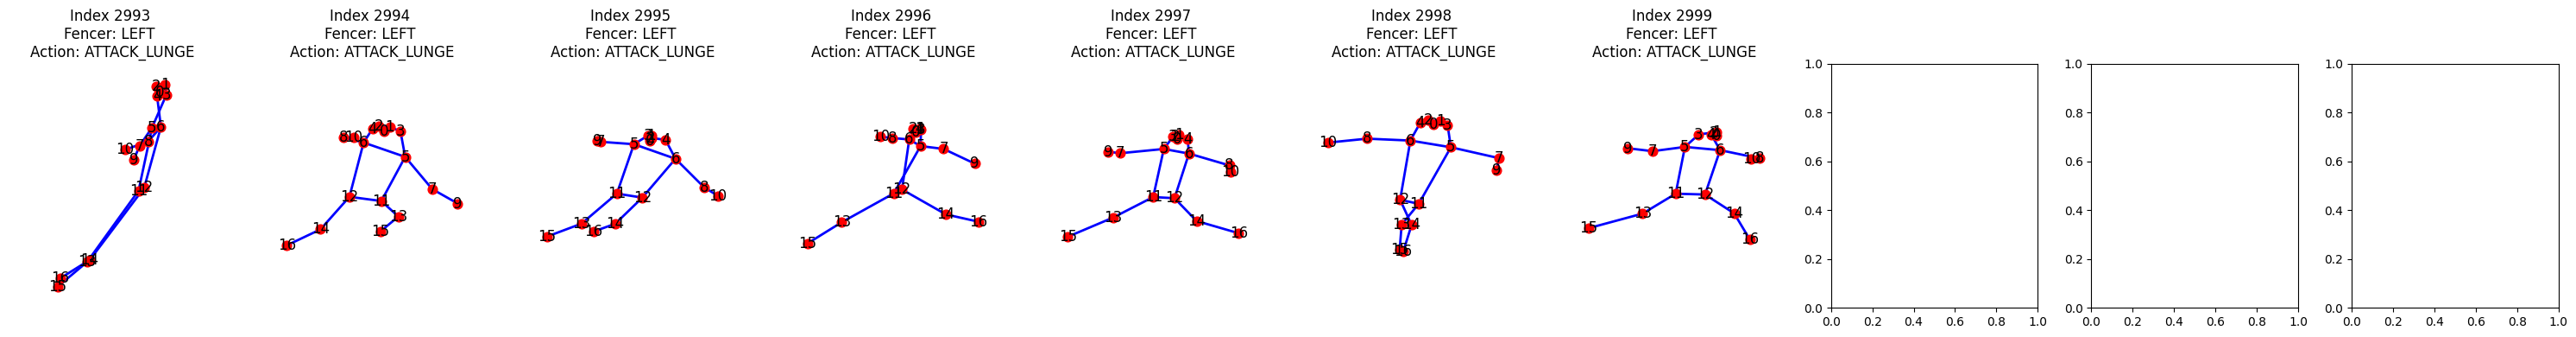

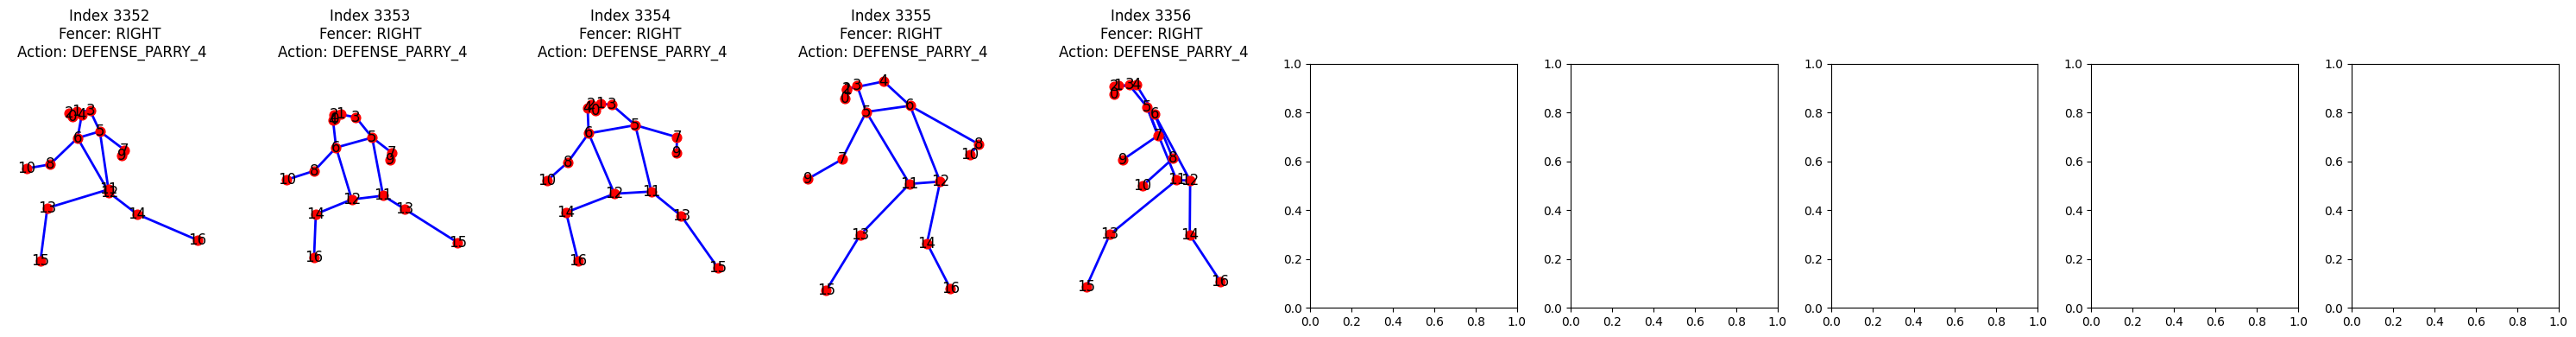

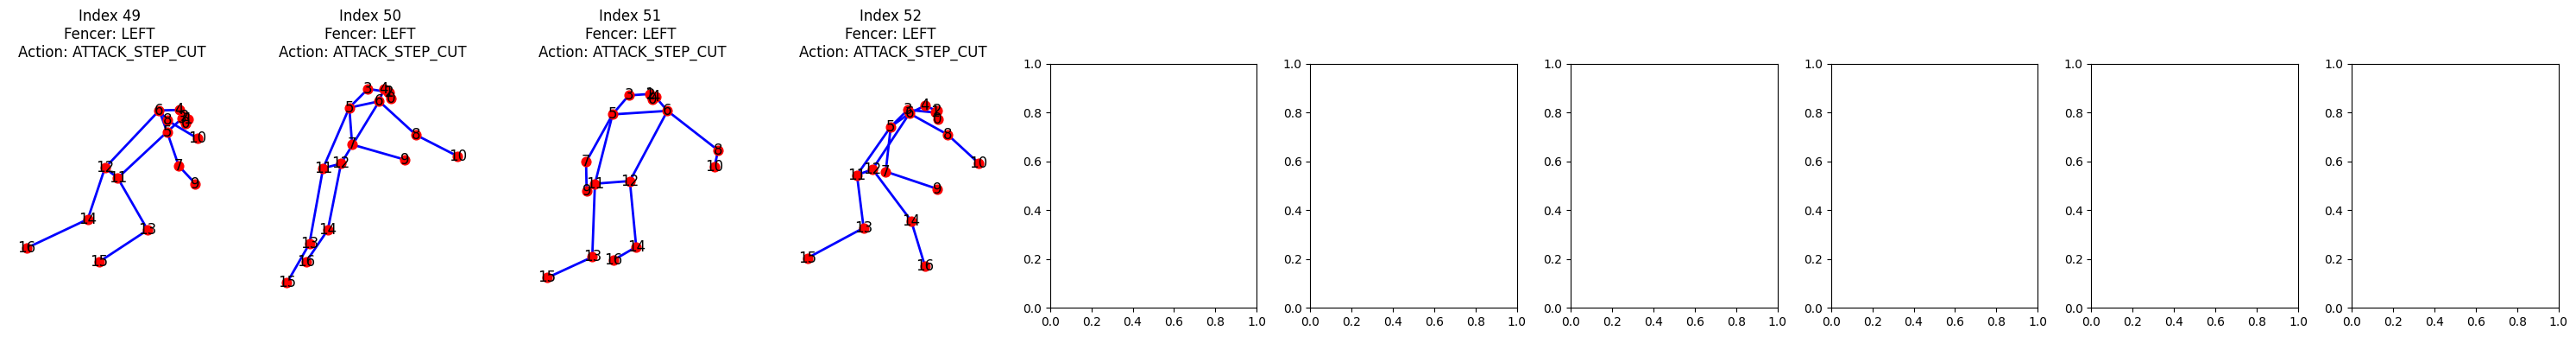

In [25]:
draw_random_action(df_merged, 3, seed=42)

count    3853.000000
mean        0.877446
std         0.114527
min         0.088428
25%         0.855658
50%         0.910002
75%         0.939267
max         0.992079
Name: confidences, dtype: float64

Number of low confidence frames:  232

3582    0.681873
826     0.663132
175     0.445792
2863    0.560990
277     0.422009
3278    0.643301
349     0.443015
3247    0.427956
2400    0.655226
1753    0.636439
Name: confidences, dtype: float64


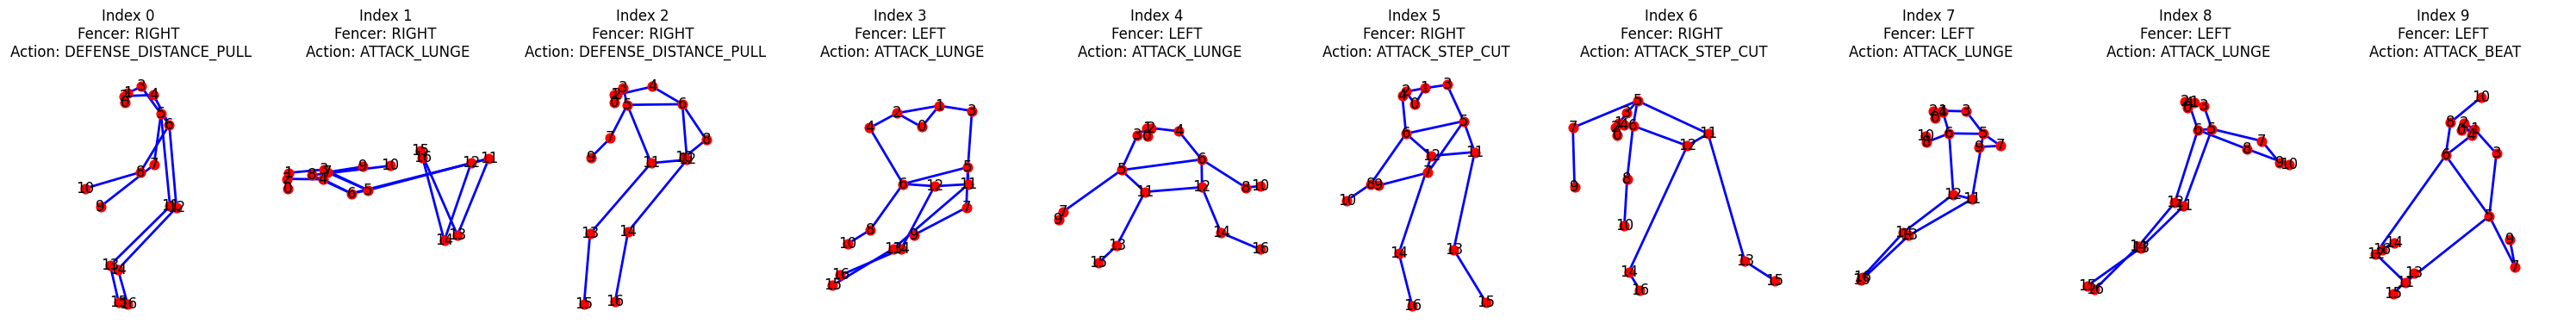

In [26]:
confidences_no_head = df_merged["confidences"].apply(lambda x: x[4:])
confidences = confidences_no_head.apply(lambda x: np.mean([c for c in x if c is not None]))
df_low_confidence = df_merged[confidences < LOW_CONFIDENCE_THRESHOLD]

print(confidences.describe())
print("")
print("Number of low confidence frames: ", len(df_low_confidence))

sample = df_low_confidence.sample(min(10, len(df_low_confidence)), random_state=42)
sample_confidences = confidences.loc[sample.index]

print("")
print(sample_confidences)

plot_poses(df_low_confidence, 0, len(sample)-1, 10)

/tmp/ipykernel_2655/1140622886.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_min_confidence = df_reduced[confidences < LOW_CONFIDENCE_THRESHOLD + 0.01]


Number of low confidence frames:  15

1900    0.706853
2295    0.701431
282     0.700872
2390    0.704995
931     0.704531
1832    0.703519
479     0.701628
470     0.704348
2391    0.701627
748     0.705626
Name: confidences, dtype: float64


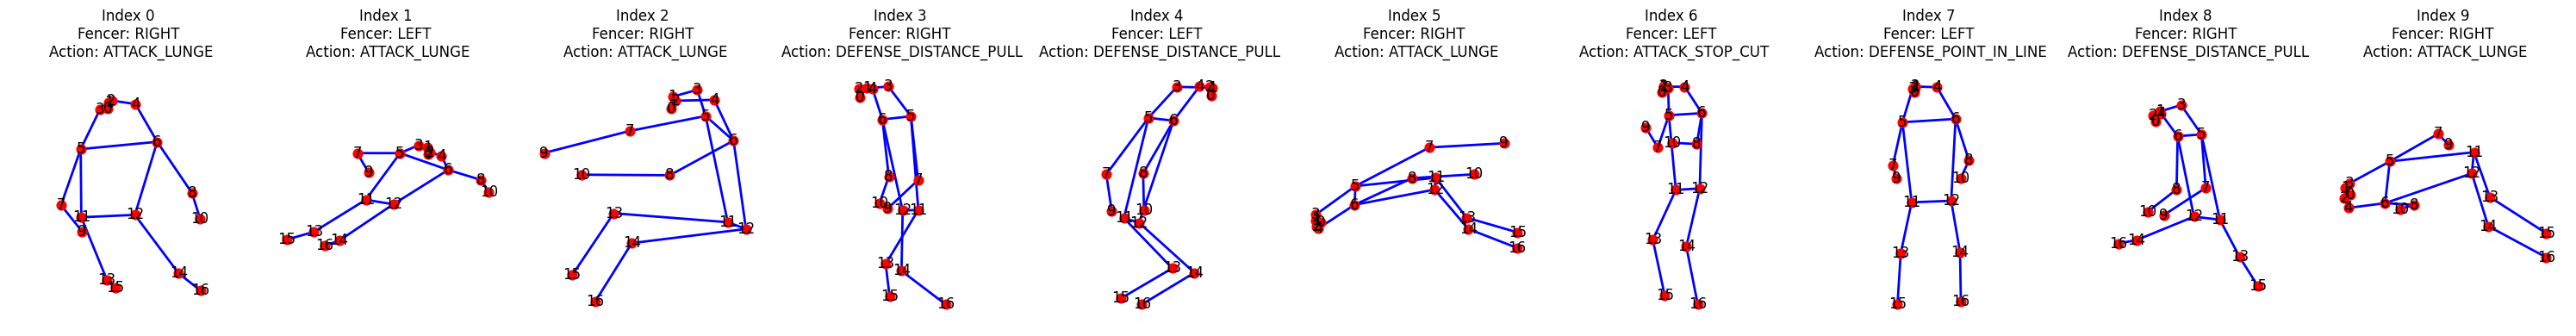

In [27]:
df_reduced = df_merged[confidences >= LOW_CONFIDENCE_THRESHOLD]
df_min_confidence = df_reduced[confidences < LOW_CONFIDENCE_THRESHOLD + 0.01]

print("Number of low confidence frames: ", len(df_min_confidence))
print("")

sample = df_min_confidence.sample(min(10, len(df_min_confidence)), random_state=42)
sample_confidences = confidences.loc[sample.index]

print(sample_confidences)
plot_poses(sample, 0, len(sample)-1, 10)

In [10]:
df_interpolated, stats = interpolate_frames(df_reduced)
df_interpolated = df_interpolated.drop(columns=["confidences"])

expected_frame_difference = stats["interpolated_frames"] + stats["copied_frames"] - stats["dropped"]
actual_frame_difference = len(df_interpolated) - len(df_reduced)

print("==== Interpolation Statistics ====")
print(stats.to_string())
print("")

print("Frame count before interpolation: ", len(df_reduced))
print("Frame count after interpolation:  ", len(df_interpolated))
print("")

print("Expected frame count difference: ", expected_frame_difference)
print("Actual frame count difference:   ", actual_frame_difference)

def keypoints_to_tuples(kp):
    arr = np.array(kp, dtype=float)
    return [(float(x), float(y)) for x, y in arr]

df_interpolated["keypoints"] = df_interpolated["keypoints"].apply(keypoints_to_tuples)

df_interpolated = df_interpolated[["file", "fencer", "action_id","action", "frame", "start_frame", "end_frame", "keypoints"]].reset_index(drop=True)
df_interpolated.to_csv(PATH_KEYPOINTS_FILTERED, index=False)

==== Interpolation Statistics ====
processed              472
dropped                 10
skipped                246
interpolated           216
interpolated_frames    356
copied_frames          203

Frame count before interpolation:  3621
Frame count after interpolation:   4170

Expected frame count difference:  549
Actual frame count difference:    549


## Data Augmentation

In [38]:
df_interpolated = pd.read_csv(PATH_KEYPOINTS_FILTERED)
df_interpolated["keypoints"] = df_interpolated["keypoints"].apply(ast.literal_eval)

df_augmented = duplicate_and_flip_actions(
    df_interpolated, 
    image_width=1920
)

df_augmented = create_action_windows(
    df_augmented, 
    window_size=MINIMUM_DURATION, 
    windows_per_action=WINDOWS_PER_ACTION, 
    random_state=42
)

df_augmented = augment_all_actions(df_augmented,
    jitter_std=JITTER_STD,
    noise_std=NOISE_STD,
    scale_std=SCALE_STD,
    rotate_deg=ROTATE_DEG
)

df_augmented = df_augmented[
    ["file", "fencer", "action_id", "window_id", "action", "frame", "start_frame", "end_frame", "keypoints"]
].sort_values(["file", "action_id", "window_id", "frame"]).reset_index(drop=True)

print(df_augmented)
print("")

print("Number of actions before augmentation: ", df_interpolated["action_id"].nunique())
print("Number of actions after augmentation:  ", df_augmented["window_id"].nunique())

                 file fencer  action_id  window_id          action  frame  \
0      /1/10_Left.mp4  RIGHT        1.0          1    ATTACK_LUNGE   21.0   
1      /1/10_Left.mp4  RIGHT        1.0          1    ATTACK_LUNGE   22.0   
2      /1/10_Left.mp4  RIGHT        1.0          1    ATTACK_LUNGE   23.0   
3      /1/10_Left.mp4  RIGHT        1.0          1    ATTACK_LUNGE   24.0   
4      /1/10_Left.mp4  RIGHT        1.0          2    ATTACK_LUNGE   23.0   
...               ...    ...        ...        ...             ...    ...   
12707   /6/9_Left.mp4   LEFT      936.0       3177  ATTACK_COUNTER   41.0   
12708   /6/9_Left.mp4   LEFT      936.0       3178  ATTACK_COUNTER   39.0   
12709   /6/9_Left.mp4   LEFT      936.0       3178  ATTACK_COUNTER   40.0   
12710   /6/9_Left.mp4   LEFT      936.0       3178  ATTACK_COUNTER   41.0   
12711   /6/9_Left.mp4   LEFT      936.0       3178  ATTACK_COUNTER   42.0   

       start_frame  end_frame  \
0             21.0       27.0   
1        

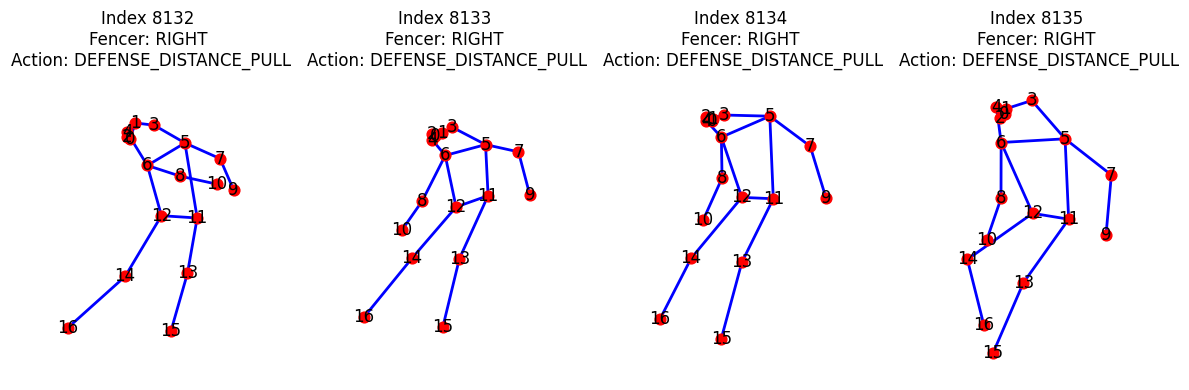

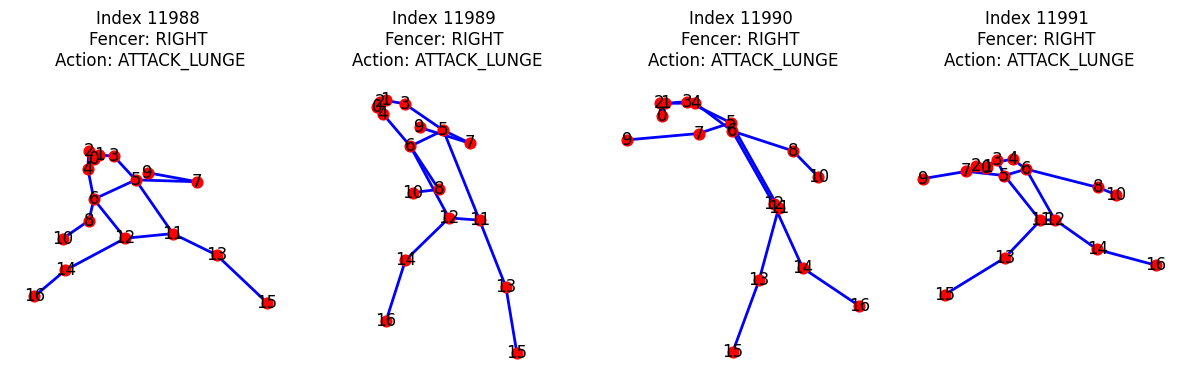

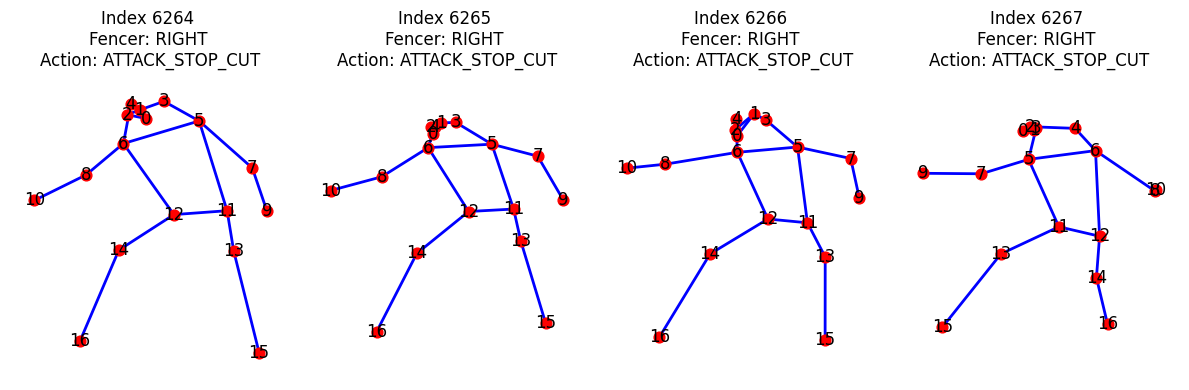

In [12]:
draw_random_window(df_augmented, 3, seed=42)

In [ ]:
df_metadata = df_augmented[["file", "fencer", "action_id", "window_id", "action", "frame", "start_frame", "end_frame"]]
df_metadata.to_csv(PATH_METADATA, index=False)

df_data = df_augmented[["window_id", "frame", "action", "keypoints"]]
df_data.sort_values(["window_id"], inplace=True)

df_data = explode_keypoints(df_data)
df_data.to_csv(PATH_DATA, index=False)

/tmp/ipykernel_2655/1610606845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.sort_values(["window_id"], inplace=True)
